In [8]:
import optuna
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam, SGD
from optuna.samplers import TPESampler, GridSampler

In [9]:
#test.csv,train.csvを取得
X_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/X_train.csv"
y_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/y_train.csv"
X_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/X_test.csv"
y_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/y_test.csv"
df_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/df_train.csv"
df_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/df_test.csv"

# Numpy配列としてよみこむ
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

# dfはDataFrameとしてよみこむ
df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

print(X_train.shape[1])

25


In [10]:
rmses = []
folds = 10

def create_model(trial):
    inputs = Input(shape=(25,))

    # 入力層を作成
    x = Dense(25, activation='relu')(inputs)

    # 中間層の作成
    # ハイパーパラメータの最適化
    n_layers = trial.suggest_int('n_layers', 1, 20)
    units = trial.suggest_int('n_units', 8, 1024, step=8)
    for i in range(n_layers):
        x = Dense(units=units/(2**(i-1)), activation='relu')(x)
        x = Dropout(0.2)(x)
        
    x = Flatten()(x)

    # 出力層の作成
    predictions = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=predictions)

    # オプティマイザと学習率の最適化
    # optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'RMSProp'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    # if optimizer_name == 'adam':
    #     optimizer = Adam()
    # if optimizer_name == 'sgd':
    #     optimizer = SGD(learning_rate=lr)
    # else:
    #     optimizer = 'RMSProp'

    model.compile(optimizer="adam", loss='mean_squared_error')

    return model

def objective(trial):
    # モデルの作成
    model = create_model(trial)

    # batch_size範囲を指定
    batch_size = trial.suggest_int('batch_size', 16, 1024, step=16)

    # KFold のオブジェクトを作成
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    
    for train_index, valid_index in kf.split(X_train, y_train):
        X_train_subset = X_train.loc[train_index].values
        y_train_subset = y_train.loc[train_index].values
        X_valid_subset = X_train.loc[valid_index].values
        y_valid_subset = y_train.loc[valid_index].values

        # トレーニング
        model.fit(
            X_train_subset, y_train_subset, 
            batch_size=batch_size,
            epochs=100, 
            verbose=0
        )

        # 予測
        y_pred = model.predict(X_valid_subset)

        # NaN が含まれているか確認
        if np.isnan(y_pred).any():
            print(" NaN が含まれているので関数から抜け出します。")
            return 

        # RMSEを算出
        temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_subset, y_pred))

        # RMSEをリストにappend
        rmses.append(temp_rmse_valid)

    # CVのRMSEの平均値を目的関数として返す
    return np.mean(rmses)
    

# ------------------------------------
# # ベイズ最適化
sampler = TPESampler()
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finalized trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# 最適なパラメータの表示

for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2023-12-18 16:40:49,117] A new study created in memory with name: no-name-b4c81b5c-3271-4ce1-a53b-3d847d403b7b
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:41:03,206] Trial 0 finished with value: 15.290605163260029 and parameters: {'n_layers': 5, 'n_units': 480, 'lr': 0.0016976007475112426, 'batch_size': 224}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:41:40,451] Trial 1 finished with value: 91.06190333776988 and parameters: {'n_layers': 11, 'n_units': 824, 'lr': 8.836268379363881e-05, 'batch_size': 256}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:41:47,320] Trial 2 finished with value: 116.49769378373362 and parameters: {'n_layers': 17, 'n_units': 56, 'lr': 0.012596149296983801, 'batch_size': 432}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:41:59,357] Trial 3 finished with value: 103.51771308317625 and parameters: {'n_layers': 9, 'n_units': 504, 'lr': 0.02118154524198443, 'batch_size': 416}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:42:08,222] Trial 4 finished with value: 116.28802539439079 and parameters: {'n_layers': 17, 'n_units': 232, 'lr': 0.0001915466507711044, 'batch_size': 944}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:42:15,345] Trial 5 finished with value: 104.42095274034251 and parameters: {'n_layers': 7, 'n_units': 160, 'lr': 0.0005629514300756214, 'batch_size': 928}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:42:30,313] Trial 6 finished with value: 103.11709205815252 and parameters: {'n_layers': 10, 'n_units': 584, 'lr': 0.00021382554553890155, 'batch_size': 480}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:42:38,891] Trial 7 finished with value: 111.14861488397419 and parameters: {'n_layers': 19, 'n_units': 192, 'lr': 0.003183094018713751, 'batch_size': 400}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 3ms/step


[I 2023-12-18 16:48:35,837] Trial 8 finished with value: 116.08591115631985 and parameters: {'n_layers': 14, 'n_units': 912, 'lr': 0.0749733576263344, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:49:08,543] Trial 9 finished with value: 121.16046491529227 and parameters: {'n_layers': 14, 'n_units': 744, 'lr': 0.002796925099313464, 'batch_size': 208}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:49:13,260] Trial 10 finished with value: 111.85987684142438 and parameters: {'n_layers': 1, 'n_units': 408, 'lr': 1.175102502371808e-05, 'batch_size': 720}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:49:55,030] Trial 11 finished with value: 103.6736222253819 and parameters: {'n_layers': 5, 'n_units': 912, 'lr': 5.870291635715614e-05, 'batch_size': 192}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:50:20,012] Trial 12 finished with value: 96.69458280571133 and parameters: {'n_layers': 3, 'n_units': 720, 'lr': 0.0012617368026865271, 'batch_size': 192}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:51:25,802] Trial 13 finished with value: 100.90095666225653 and parameters: {'n_layers': 12, 'n_units': 392, 'lr': 4.651509108261259e-05, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:51:44,973] Trial 14 finished with value: 95.73880988278312 and parameters: {'n_layers': 7, 'n_units': 704, 'lr': 0.0005247823112440286, 'batch_size': 640}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 3ms/step


[I 2023-12-18 16:52:38,456] Trial 15 finished with value: 90.76358373333443 and parameters: {'n_layers': 6, 'n_units': 1024, 'lr': 0.0017376514639559765, 'batch_size': 272}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:53:28,133] Trial 16 finished with value: 86.2306549995742 and parameters: {'n_layers': 4, 'n_units': 1008, 'lr': 0.002939331479212106, 'batch_size': 288}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:53:32,777] Trial 17 finished with value: 82.38611733608238 and parameters: {'n_layers': 1, 'n_units': 592, 'lr': 0.006871419368089015, 'batch_size': 672}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:53:37,322] Trial 18 finished with value: 78.95302953355424 and parameters: {'n_layers': 1, 'n_units': 552, 'lr': 0.009291828669671124, 'batch_size': 656}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:53:46,364] Trial 19 finished with value: 75.74316038051009 and parameters: {'n_layers': 3, 'n_units': 376, 'lr': 0.04406262302024838, 'batch_size': 848}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:53:53,892] Trial 20 finished with value: 72.84162381537728 and parameters: {'n_layers': 3, 'n_units': 352, 'lr': 0.08195793053896785, 'batch_size': 832}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:54:01,233] Trial 21 finished with value: 70.22172907455153 and parameters: {'n_layers': 3, 'n_units': 336, 'lr': 0.05891906272374666, 'batch_size': 784}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:54:08,663] Trial 22 finished with value: 67.81498182727071 and parameters: {'n_layers': 4, 'n_units': 320, 'lr': 0.09532933929661422, 'batch_size': 784}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:54:16,373] Trial 23 finished with value: 67.25125056284404 and parameters: {'n_layers': 8, 'n_units': 280, 'lr': 0.03028063654739322, 'batch_size': 576}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:54:23,845] Trial 24 finished with value: 66.7426241355703 and parameters: {'n_layers': 8, 'n_units': 264, 'lr': 0.027855185317537546, 'batch_size': 560}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:54:28,348] Trial 25 finished with value: 70.61287992450936 and parameters: {'n_layers': 8, 'n_units': 8, 'lr': 0.01564424483200387, 'batch_size': 576}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:54:39,394] Trial 26 finished with value: 70.33685984009628 and parameters: {'n_layers': 8, 'n_units': 472, 'lr': 0.03052946148432163, 'batch_size': 544}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:54:48,584] Trial 27 finished with value: 73.78317155403361 and parameters: {'n_layers': 12, 'n_units': 136, 'lr': 0.006719467890297093, 'batch_size': 352}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:55:01,029] Trial 28 finished with value: 71.82180567790145 and parameters: {'n_layers': 6, 'n_units': 272, 'lr': 0.02845937048837014, 'batch_size': 112}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:55:09,074] Trial 29 finished with value: 72.64189169782016 and parameters: {'n_layers': 10, 'n_units': 264, 'lr': 0.03544995495137414, 'batch_size': 496}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:55:20,506] Trial 30 finished with value: 75.69761372800039 and parameters: {'n_layers': 11, 'n_units': 448, 'lr': 0.017013978475081216, 'batch_size': 592}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:55:27,698] Trial 31 finished with value: 73.83136785418384 and parameters: {'n_layers': 5, 'n_units': 304, 'lr': 0.08969931380010547, 'batch_size': 720}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:55:33,193] Trial 32 finished with value: 76.66586486712488 and parameters: {'n_layers': 8, 'n_units': 104, 'lr': 0.03182494098512478, 'batch_size': 1008}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:55:40,773] Trial 33 finished with value: 74.92662221532191 and parameters: {'n_layers': 5, 'n_units': 224, 'lr': 0.04808819323678945, 'batch_size': 336}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:55:58,700] Trial 34 finished with value: 73.84586250639597 and parameters: {'n_layers': 9, 'n_units': 632, 'lr': 0.09617734989436307, 'batch_size': 448}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:56:09,612] Trial 35 finished with value: 72.34788764734807 and parameters: {'n_layers': 7, 'n_units': 456, 'lr': 0.018120795947386744, 'batch_size': 768}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:56:14,462] Trial 36 finished with value: 71.71864415518792 and parameters: {'n_layers': 6, 'n_units': 72, 'lr': 0.011277003291839697, 'batch_size': 608}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:56:21,172] Trial 37 finished with value: 74.23577901324313 and parameters: {'n_layers': 9, 'n_units': 192, 'lr': 0.049435177991328995, 'batch_size': 512}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:56:31,895] Trial 38 finished with value: 72.70286502387152 and parameters: {'n_layers': 4, 'n_units': 504, 'lr': 0.020869721455332814, 'batch_size': 896}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:56:41,039] Trial 39 finished with value: 75.06952526440168 and parameters: {'n_layers': 13, 'n_units': 312, 'lr': 0.004837821428090346, 'batch_size': 416}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:56:49,795] Trial 40 finished with value: 77.3207386636101 and parameters: {'n_layers': 16, 'n_units': 248, 'lr': 0.02494186102937382, 'batch_size': 704}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:56:55,821] Trial 41 finished with value: 75.84990239390025 and parameters: {'n_layers': 2, 'n_units': 328, 'lr': 0.05484942334413525, 'batch_size': 800}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:57:05,546] Trial 42 finished with value: 74.42042871449188 and parameters: {'n_layers': 4, 'n_units': 400, 'lr': 0.0625438398765721, 'batch_size': 752}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:57:09,892] Trial 43 finished with value: 73.09593458342044 and parameters: {'n_layers': 2, 'n_units': 160, 'lr': 0.01179237969472189, 'batch_size': 912}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:57:17,642] Trial 44 finished with value: 72.36609963260322 and parameters: {'n_layers': 7, 'n_units': 296, 'lr': 0.05282037525261446, 'batch_size': 976}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:57:30,327] Trial 45 finished with value: 74.43138604582266 and parameters: {'n_layers': 20, 'n_units': 424, 'lr': 0.0692488735082754, 'batch_size': 864}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:57:47,308] Trial 46 finished with value: 73.16858786486686 and parameters: {'n_layers': 5, 'n_units': 360, 'lr': 0.02199624656713395, 'batch_size': 80}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 16:57:52,041] Trial 47 finished with value: 71.9768036686659 and parameters: {'n_layers': 2, 'n_units': 200, 'lr': 0.09591835572288757, 'batch_size': 560}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:58:04,064] Trial 48 finished with value: 70.84076731285379 and parameters: {'n_layers': 6, 'n_units': 520, 'lr': 0.03923126008356079, 'batch_size': 368}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:58:19,755] Trial 49 finished with value: 69.71110405197362 and parameters: {'n_layers': 4, 'n_units': 640, 'lr': 0.015113886044614715, 'batch_size': 448}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:58:37,873] Trial 50 finished with value: 69.6815552894643 and parameters: {'n_layers': 9, 'n_units': 640, 'lr': 0.00404675270493732, 'batch_size': 624}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:58:56,254] Trial 51 finished with value: 71.56017481640569 and parameters: {'n_layers': 10, 'n_units': 664, 'lr': 0.004225852745420541, 'batch_size': 448}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:59:17,461] Trial 52 finished with value: 70.74146870228454 and parameters: {'n_layers': 8, 'n_units': 752, 'lr': 0.008477742477179074, 'batch_size': 624}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 16:59:33,108] Trial 53 finished with value: 70.65110829099271 and parameters: {'n_layers': 9, 'n_units': 600, 'lr': 0.01400974663154775, 'batch_size': 688}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:00:05,574] Trial 54 finished with value: 69.6092242404059 and parameters: {'n_layers': 4, 'n_units': 808, 'lr': 0.0012352178101695027, 'batch_size': 224}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:00:53,118] Trial 55 finished with value: 68.70505896754818 and parameters: {'n_layers': 7, 'n_units': 824, 'lr': 0.0019173467108409418, 'batch_size': 160}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:01:30,335] Trial 56 finished with value: 67.84414517351564 and parameters: {'n_layers': 7, 'n_units': 856, 'lr': 0.001557630484720435, 'batch_size': 224}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:02:37,855] Trial 57 finished with value: 66.99636106176862 and parameters: {'n_layers': 7, 'n_units': 872, 'lr': 0.0008164460810011131, 'batch_size': 96}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:04:03,612] Trial 58 finished with value: 66.11022413677469 and parameters: {'n_layers': 6, 'n_units': 912, 'lr': 0.0005064499905504823, 'batch_size': 80}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:05:59,268] Trial 59 finished with value: 65.27555189401586 and parameters: {'n_layers': 6, 'n_units': 976, 'lr': 0.0006653224197189677, 'batch_size': 64}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:07:34,175] Trial 60 finished with value: 64.45303338786847 and parameters: {'n_layers': 6, 'n_units': 968, 'lr': 0.0007392939896959915, 'batch_size': 80}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:09:23,319] Trial 61 finished with value: 63.644648674034514 and parameters: {'n_layers': 6, 'n_units': 952, 'lr': 0.0005868611536643879, 'batch_size': 64}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:11:15,440] Trial 62 finished with value: 62.85247166998446 and parameters: {'n_layers': 5, 'n_units': 968, 'lr': 0.00047826662507575605, 'batch_size': 64}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:13:41,037] Trial 63 finished with value: 62.08968387873661 and parameters: {'n_layers': 5, 'n_units': 976, 'lr': 0.0003492122782910211, 'batch_size': 48}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 3ms/step


[I 2023-12-18 17:16:12,107] Trial 64 finished with value: 61.3471238575544 and parameters: {'n_layers': 5, 'n_units': 992, 'lr': 0.00037388099794984824, 'batch_size': 48}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:18:40,897] Trial 65 finished with value: 60.6440863973272 and parameters: {'n_layers': 5, 'n_units': 984, 'lr': 0.00035386564697128414, 'batch_size': 48}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:25:04,657] Trial 66 finished with value: 59.937908234277145 and parameters: {'n_layers': 5, 'n_units': 968, 'lr': 0.0003593148593602945, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:31:21,532] Trial 67 finished with value: 59.26016654763378 and parameters: {'n_layers': 5, 'n_units': 952, 'lr': 0.0003217749222217621, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:38:23,970] Trial 68 finished with value: 58.600334693974574 and parameters: {'n_layers': 5, 'n_units': 1016, 'lr': 0.00038031061259177014, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:45:09,652] Trial 69 finished with value: 57.94093829704037 and parameters: {'n_layers': 3, 'n_units': 1016, 'lr': 0.0002479976468109476, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:51:55,961] Trial 70 finished with value: 57.29699906918185 and parameters: {'n_layers': 3, 'n_units': 1016, 'lr': 0.00020927162171221266, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 17:58:46,287] Trial 71 finished with value: 56.66443444712147 and parameters: {'n_layers': 3, 'n_units': 1016, 'lr': 0.0001997045982011211, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:05:32,873] Trial 72 finished with value: 56.04402158851199 and parameters: {'n_layers': 3, 'n_units': 1016, 'lr': 0.0001808699050343995, 'batch_size': 16}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:06:41,954] Trial 73 finished with value: 55.45504262158179 and parameters: {'n_layers': 3, 'n_units': 1024, 'lr': 0.0001601762743040955, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:07:38,620] Trial 74 finished with value: 54.88405907586785 and parameters: {'n_layers': 3, 'n_units': 936, 'lr': 0.00016085934889308926, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:07:46,166] Trial 75 finished with value: 54.347056151695526 and parameters: {'n_layers': 1, 'n_units': 1024, 'lr': 0.00016621660363759904, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:07:53,298] Trial 76 finished with value: 53.82698359871077 and parameters: {'n_layers': 1, 'n_units': 920, 'lr': 0.00014875529773054118, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:08:40,773] Trial 77 finished with value: 53.31331950181781 and parameters: {'n_layers': 2, 'n_units': 920, 'lr': 0.0001418888250478903, 'batch_size': 128}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:08:47,925] Trial 78 finished with value: 52.82056951991945 and parameters: {'n_layers': 1, 'n_units': 928, 'lr': 0.00014189965671053788, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:08:55,039] Trial 79 finished with value: 52.3474480433313 and parameters: {'n_layers': 1, 'n_units': 888, 'lr': 0.00013120756143639994, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:09:02,166] Trial 80 finished with value: 51.878482525412345 and parameters: {'n_layers': 1, 'n_units': 880, 'lr': 0.00011911498777046998, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:09:09,480] Trial 81 finished with value: 51.42277805529514 and parameters: {'n_layers': 1, 'n_units': 888, 'lr': 0.0001232551131691554, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:09:16,810] Trial 82 finished with value: 50.98389081064157 and parameters: {'n_layers': 1, 'n_units': 880, 'lr': 0.00011949135880752429, 'batch_size': 144}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:09:23,944] Trial 83 finished with value: 50.56081378586425 and parameters: {'n_layers': 1, 'n_units': 880, 'lr': 9.658676436193757e-05, 'batch_size': 176}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:09:30,257] Trial 84 finished with value: 50.148239028437835 and parameters: {'n_layers': 1, 'n_units': 880, 'lr': 9.574506811630039e-05, 'batch_size': 256}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:10:01,807] Trial 85 finished with value: 49.73251393486845 and parameters: {'n_layers': 2, 'n_units': 880, 'lr': 9.518620683129972e-05, 'batch_size': 304}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:10:08,348] Trial 86 finished with value: 49.333105685790535 and parameters: {'n_layers': 1, 'n_units': 888, 'lr': 7.431319934014331e-05, 'batch_size': 304}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:10:39,250] Trial 87 finished with value: 48.93935291030762 and parameters: {'n_layers': 2, 'n_units': 872, 'lr': 8.499019560342599e-05, 'batch_size': 288}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:11:09,030] Trial 88 finished with value: 48.552980150391605 and parameters: {'n_layers': 2, 'n_units': 856, 'lr': 7.131086681631509e-05, 'batch_size': 304}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:11:35,132] Trial 89 finished with value: 48.17090965537953 and parameters: {'n_layers': 2, 'n_units': 776, 'lr': 6.973845395207638e-05, 'batch_size': 288}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:11:59,961] Trial 90 finished with value: 47.80777880624675 and parameters: {'n_layers': 2, 'n_units': 776, 'lr': 5.511535630924446e-05, 'batch_size': 304}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:12:26,542] Trial 91 finished with value: 47.44158000829938 and parameters: {'n_layers': 2, 'n_units': 784, 'lr': 6.99215692317051e-05, 'batch_size': 304}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:12:53,338] Trial 92 finished with value: 47.08637615669307 and parameters: {'n_layers': 2, 'n_units': 800, 'lr': 6.47737041603603e-05, 'batch_size': 288}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:13:19,564] Trial 93 finished with value: 46.73671669598512 and parameters: {'n_layers': 2, 'n_units': 768, 'lr': 5.918229779026661e-05, 'batch_size': 288}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:13:43,320] Trial 94 finished with value: 46.397264833251505 and parameters: {'n_layers': 2, 'n_units': 760, 'lr': 5.801206967402527e-05, 'batch_size': 304}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:14:06,758] Trial 95 finished with value: 46.05988739978004 and parameters: {'n_layers': 2, 'n_units': 744, 'lr': 6.122465904906318e-05, 'batch_size': 320}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:14:23,844] Trial 96 finished with value: 45.74292679539068 and parameters: {'n_layers': 2, 'n_units': 776, 'lr': 3.9015455619524515e-05, 'batch_size': 384}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:14:41,452] Trial 97 finished with value: 45.42966478479817 and parameters: {'n_layers': 2, 'n_units': 776, 'lr': 4.227234723264754e-05, 'batch_size': 384}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-18 18:14:59,083] Trial 98 finished with value: 45.12019087819777 and parameters: {'n_layers': 2, 'n_units': 784, 'lr': 3.8215478227739865e-05, 'batch_size': 384}. Best is trial 0 with value: 15.290605163260029.
/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-18 18:15:15,622] Trial 99 finished with value: 44.82398496684194 and parameters: {'n_layers': 2, 'n_units': 704, 'lr': 4.191412964516362e-05, 'batch_size': 384}. Best is trial 0 with value: 15.290605163260029.


Number of finalized trials: 100
Best trial: {'n_layers': 5, 'n_units': 480, 'lr': 0.0016976007475112426, 'batch_size': 224}
    n_layers: 5
    n_units: 480
    lr: 0.0016976007475112426
    batch_size: 224


224


/tmp/ipykernel_40998/2470216691.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


dict_keys(['loss'])
{'loss': [28148.05859375, 27815.5078125, 27037.59375, 25405.94140625, 22350.908203125, 17094.27734375, 9911.755859375, 5337.54345703125, 8128.36669921875, 6097.10498046875, 3278.556396484375, 3504.14697265625, 4177.31494140625, 3858.565185546875, 2605.807373046875, 2008.177734375, 2669.907470703125, 2558.37255859375, 2084.993408203125, 1929.2655029296875, 1991.3912353515625, 1950.8341064453125, 1613.3778076171875, 1497.854736328125, 1647.8470458984375, 1491.3623046875, 1439.065185546875, 1398.667236328125, 1497.027099609375, 1336.8302001953125, 1313.8404541015625, 1435.9508056640625, 1303.7481689453125, 1388.4637451171875, 1135.337890625, 1391.265869140625, 1439.9959716796875, 1215.1085205078125, 1287.2919921875, 1227.8638916015625, 1076.560302734375, 1031.8685302734375, 975.472412109375, 984.5286254882812, 931.3916015625, 1168.6800537109375, 1073.1522216796875, 965.2515258789062, 903.6217651367188, 1000.0065307617188, 805.4758911132812, 1024.8470458984375, 907.2164

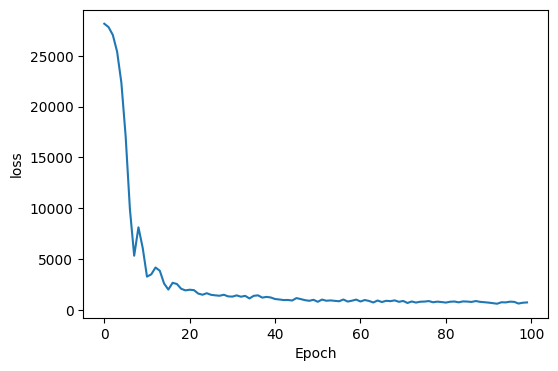

1/1 [==============================] - 0s 11ms/step
Final MSE on test data: 4942.392812790814
Finished ML_10_trial_op3.py


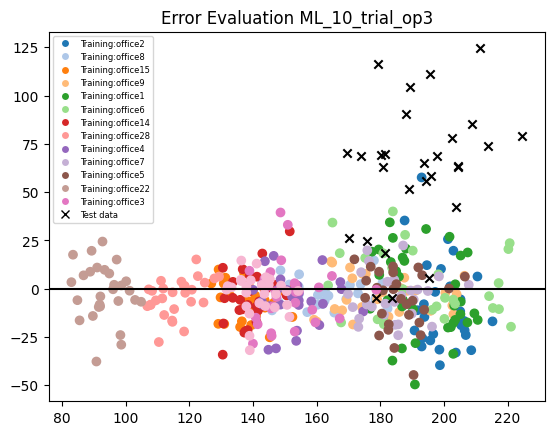

In [11]:
best_batch_size = study.best_trial.params['batch_size']
print(best_batch_size)
# 最適なパラメータを使ってモデルの作成
best_model = create_model(study.best_trial)
train_history = best_model.fit(
                                X_train, y_train, 
                                batch_size=best_batch_size,
                                epochs=100, 
                                verbose=0
                                )

print(train_history.history.keys())

print(train_history.history)
print(len(train_history.history['loss']))

# エポックごとの損失関数値をプロットしてみる
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(train_history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
plt.show()

# 評価
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_test_pred)
print('Final MSE on test data:', final_mse)
# print(y_test_pred)


# 図を作成するための準備
df_train['predict values'] = y_train_pred
df_train['residuals'] = y_train_pred - y_train
df_test['predict values'] = y_test_pred
df_test['residuals'] = y_test_pred - y_test


#df_trainに'legend'列を追加(凡例)
root_directory = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/"
for folder_name in os.listdir(root_directory):  
        for index,row in df_train.iterrows() :           #１行ずつ実行
                if folder_name + '_' in row['case_name']:                 #case_nameにfolder_nameが含まれているかどうか
                        df_train.loc[index,'legend'] = 'Training:' + folder_name

df_test['legend'] = 'Test data'

df_forfig = pd.concat([df_train, df_test])
# df_forfig.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_5/df_forfig XGB.csv"\
#                         ,encoding='utf_8_sig', index=False)

#-----Error Evaluation (+test) DTR.pdfの作成-------------------------------------------
# 各オフィス名に対する色を 'tab20' カラーマップから取得
legend_names = df_train['legend'].unique()      #unique()メソッドは指定した列内の一意の値の配列を返す（重複を取り除く）
# print(legend_names)
colors = plt.cm.tab20(range(len(legend_names))) #tab20から配列legemd_namesの長さ分の色の配列colorsを返す
# 凡例名と色の対応を辞書に格納
# zip関数は２つ以上のリストを取り、それらの対応する要素をペアにしてイテレータを返す。
# この場合、legend_namesとcolorsの２つのリストをペアにし、対応する要素同士を取得する。
# =以降はofficeをキーとしてそれに対応するcolorが"値"として格納される辞書を作成
legend_color_mapping = {legend: color for legend, color in zip(legend_names, colors)}
# print(legend_color_mapping)
# 'legend' 列を数値（色情報に対応する数値）に変換
# 'legend_num'　を追加
df_train['legend_num'] = df_train['legend'].map(legend_color_mapping)
#散布図を作成
plt.scatter(df_train['predict values'], df_train['residuals'], c=df_train['legend_num'])
plt.scatter(df_test['predict values'], df_test['residuals'], c='black', marker='x' )
#y=0の直線を引く
# y = 0 の直線を描く
plt.axhline(y=0, color='black', linestyle='-')

# 凡例を作成
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, \
                        markersize=6, label=legend) for legend, color in zip(legend_names, colors)]
# Test dataの凡例を追加
handles[-1] = plt.Line2D([0], [0] ,marker='x', color='black', markersize=6, label='Test data', linestyle='None')

# 凡例を表示
plt.legend(handles=handles, loc='upper left', fontsize=6)


plt.title('Error Evaluation ML_10_trial_op3')
plt.savefig("/home/gakubu/デスクトップ/ML_git/MLT/ML_10/Error Evaluation 10 trial op3.pdf", format='pdf') 
# plt.show()
#-----------------------------------------------------------------------------------

print('Finished ML_10_trial_op3.py')



#各種評価指標をcsvファイルとして出力する
df_ee = pd.DataFrame({
                        'MSE(平均二乗誤差)': [mean_squared_error(y_test, y_test_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_test, y_test_pred)]})
df_ee.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_10/Error Evaluation 10 trial op3.csv",encoding='utf_8_sig', index=False)

df_ee_train = pd.DataFrame({
                        'MSE(平均二乗誤差)': [mean_squared_error(y_train, y_train_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_train, y_train_pred)]})
df_ee_train.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_10/Error Evaluation 10 trial op3 train.csv",encoding='utf_8_sig', index=False)